In [1]:
from typing import Set, List, Tuple
from collections import namedtuple
import tabulate

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

idx_and_arrow = namedtuple("idx_and_arrow", ["idx", "arrow"])

In [2]:
ARROW_DICT = {
    (-1, 0): "←",
    (-1, -1): "↖",
    (0, -1): "↑",
}


class Tracker:
    def __init__(self, score: int, previous_entries_idxs: Set[tuple], arrows: Set[str]):
        assert isinstance(
            previous_entries_idxs, set
        ), "previous_entries_idxs must be a set"

        self.score: int = score
        self.previous_entries_idxs: Set[tuple] = previous_entries_idxs
        self.arrows = "".join(sorted(arrows))

    def __repr__(self):
        return str(self.score) + self.arrows

    def __str__(self):
        return str(self.score) + self.arrows

In [3]:
def solve_needlemann_wunsch(v: str, w: str, match: int, mismatch: int, gap: int):
    n = len(v)
    m = len(w)

    matrix = np.empty((n + 1, m + 1), dtype=Tracker)

    for i in range(n + 1):
        matrix[i, 0] = Tracker(i * gap, {(i - 1, 0)}, set([ARROW_DICT[0, -1]]))
    for j in range(m + 1):
        matrix[0, j] = Tracker(j * gap, {(0, j - 1)}, set([ARROW_DICT[-1, 0]]))

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            match_score = matrix[i - 1, j - 1].score + (
                match if v[i - 1] == w[j - 1] else mismatch
            )
            delete_score = matrix[i - 1, j].score + gap
            insert_score = matrix[i, j - 1].score + gap

            best_score = max(match_score, delete_score, insert_score)

            equal_scores = set()
            if best_score == match_score:
                equal_scores.add(idx_and_arrow((i - 1, j - 1), ARROW_DICT[-1, -1]))
            if best_score == delete_score:
                equal_scores.add(idx_and_arrow((i - 1, j), ARROW_DICT[0, -1]))
            if best_score == insert_score:
                equal_scores.add(idx_and_arrow((i, j - 1), ARROW_DICT[-1, 0]))

            matrix[i, j] = Tracker(
                best_score,
                {x.idx for x in equal_scores},
                {x.arrow for x in equal_scores},
            )

    return matrix, matrix[n, m].score

In [4]:
def backtrack_all_paths(
    matrix: np.ndarray, i: int, j: int, v: str, w: str
) -> List[Tuple[str, str]]:
    if i == 0 and j == 0:
        return [("", "")]

    if i == 0 or j == 0:
        if i == 0:
            return [("-" * j, w[:j])]
        else:
            return [(v[:i], "-" * i)]

    paths = []
    for prev_i, prev_j in matrix[i, j].previous_entries_idxs:
        # print(prev_i, prev_j)
        path_parts = []
        # if prev_i == 0 or prev_j == 0:
        #     print("HERE WE GO!")
        if i - 1 == prev_i and j - 1 == prev_j:
            all_paths_backtracked = backtrack_all_paths(matrix, prev_i, prev_j, v, w)
            # print(all_paths_backtracked, "\n\n")
            for path_v, path_w in all_paths_backtracked:
                path_parts.append((v[i - 1] + path_v, w[j - 1] + path_w))
            paths.extend(path_parts)

        elif i - 1 == prev_i:
            for path_v, path_w in backtrack_all_paths(matrix, prev_i, prev_j, v, w):
                path_parts.append((v[i - 1] + path_v, "-" + path_w))
            paths.extend(path_parts)

        elif j - 1 == prev_j:
            for path_v, path_w in backtrack_all_paths(matrix, prev_i, prev_j, v, w):
                path_parts.append(("-" + path_v, w[j - 1] + path_w))
            paths.extend(path_parts)

    return paths

In [5]:
def backtrack_matrix(matrix, v, w):
    i, j = len(v), len(w)

    paths = backtrack_all_paths(matrix, i, j, v, w)

    reversed_paths = []
    for path_v, path_w in paths:
        reversed_paths.append((path_v[::-1], path_w[::-1]))

    return reversed_paths

In [6]:
def visualize_part(matrix: np.ndarray, v, w, viz_type, show=True):
    assert viz_type in {
        "score",
        "directions",
    }, "viz_type must be either 'score' or 'directions'"

    ret = np.empty((len(v) + 1, len(w) + 1), dtype=object)
    for i in range(len(v) + 1):
        for j in range(len(w) + 1):
            if viz_type == "score":
                ret[i, j] = matrix[i, j].score
            else:
                ret[i, j] = matrix[i, j].arrows
    ret = pd.DataFrame(ret, index=["i"] + list(v), columns=["j"] + list(w))
    if show:
        print(
            tabulate.tabulate(
                ret, tablefmt="fancy_grid", showindex=True, headers="keys"
            )
        )
    return ret

In [7]:
def generate_all_paths_recursive(matrix, i, j, path, paths):
    if i == 0 and j == 0:
        paths.append(
            path[::-1]
        )  # Reverse the path to start from the bottom-right corner
        return
    if matrix[i][j] == "←":
        generate_all_paths_recursive(matrix, i, j - 1, path + [(i, j - 1)], paths)
    elif matrix[i][j] == "↑":
        generate_all_paths_recursive(matrix, i - 1, j, path + [(i - 1, j)], paths)
    elif matrix[i][j] == "↖":
        generate_all_paths_recursive(
            matrix, i - 1, j - 1, path + [(i - 1, j - 1)], paths
        )
    elif matrix[i][j] == "←↑":
        generate_all_paths_recursive(matrix, i, j - 1, path + [(i, j - 1)], paths)
        generate_all_paths_recursive(matrix, i - 1, j, path + [(i - 1, j)], paths)
    elif matrix[i][j] == "←↖":
        generate_all_paths_recursive(matrix, i, j - 1, path + [(i, j - 1)], paths)
        generate_all_paths_recursive(
            matrix, i - 1, j - 1, path + [(i - 1, j - 1)], paths
        )
    elif matrix[i][j] == "↑↖":
        generate_all_paths_recursive(matrix, i - 1, j, path + [(i - 1, j)], paths)
        generate_all_paths_recursive(
            matrix, i - 1, j - 1, path + [(i - 1, j - 1)], paths
        )


def generate_all_paths(matrix):
    paths = []
    generate_all_paths_recursive(
        matrix,
        len(matrix) - 1,
        len(matrix[0]) - 1,
        [(len(matrix) - 1, len(matrix[0]) - 1)],
        paths,
    )
    return paths

In [8]:
def plot_path(dir_matrix, v, w):
    arrow_matrix = dir_matrix.copy().values

    paths = generate_all_paths(arrow_matrix)

    m, n = len(v) + 1, len(w) + 1
    fig, ax = plt.subplots()
    for path in paths:
        x = [cell[1] for cell in path]
        y = [m - cell[0] for cell in path]
        ax.plot(x, y, marker="o", alpha=0.5, linestyle="-", linewidth=2)

    ax.set_xlim(-1, n)
    ax.set_ylim(0, m + 1)

    ax.set_xticks([i for i in range(n)])
    ax.set_yticks([i + 1 for i in range(m)])
    ax.set_xticklabels(["j"] + list(w))
    ax.set_yticklabels(list(v[::-1]) + ["i"])
    ax.xaxis.tick_top()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.title("All Possible Paths from Bottom-Right to Top-Left")
    plt.xlabel("j")
    plt.ylabel("i")
    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.show()

In [9]:
def play(v, w, match_score, mismatch_score, gap_score, plot_only=True):
    matrix, score = solve_needlemann_wunsch(
        v, w, match_score, mismatch_score, gap_score
    )

    possible_alignments = backtrack_matrix(matrix, v, w)

    if not plot_only:
        print(matrix, score, possible_alignments, sep="\n\n\n", end="\n\n\n")

        score_matrix = visualize_part(matrix, v, w, "score", show=not plot_only)

    dir_matrix = visualize_part(matrix, v, w, "directions", show=not plot_only)

    plot_path(dir_matrix, v, w)

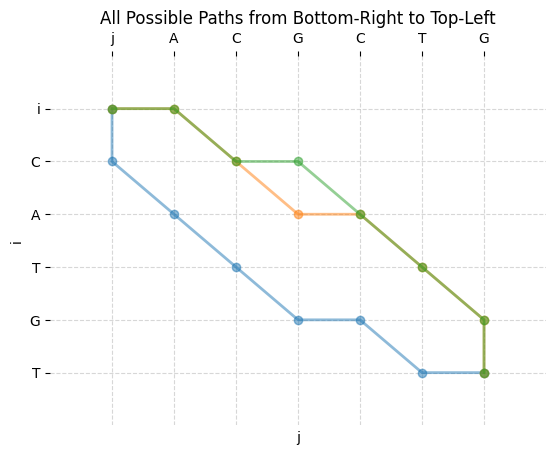

In [10]:
v = "ACGCTG"
w = "CATGT"

match_score = 2
mismatch_score = -1
gap_score = -1

pair = (w, v)

play(*pair, match_score, mismatch_score, gap_score, plot_only=True)